In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import vgg16, vgg19, alexnet
from torch.autograd import Variable

import copy

In [2]:
# instantiate models

model_vgg16 = vgg16(pretrained=True).features
model_vgg16 = model_vgg16.double()

model_vgg19 = vgg19(pretrained=True).features
model_vgg19 = model_vgg19.double()

model_alexnet = alexnet(pretrained=True).features
model_alexnet = model_alexnet.double()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [3]:
# define image transformations

class transform():
    def __init__(self):
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
    
    def initialize(self, image, isprocess):
        if isprocess:
            image = image.transpose(2, 0, 1)
            image = image / 255.
            return image
        else:
            image = torch.clamp(image, 0, 1)
            image = image * 255
            return image
        
    def normalize(self, image, isprocess):
        if isprocess:
            for channel, _ in enumerate(image):
                image[channel, :, :] = (image[channel, :, :] - self.mean[channel]) / self.std[channel]
            return image
        else:
            for channel, _ in enumerate(image):
                image[channel, :, :] = (image[channel, :, :] * self.std[channel]) + self.mean[channel]
            return image
        
class process(transform):
    def __init(self):
        super(process, self).__init__()
        
    def __call__(self, image):
        image = self.initialize(image, True)
        image = self.normalize(image, True)
        image = image[np.newaxis, :, :, :]
        image = torch.from_numpy(image).double()
        
        return torch.autograd.Variable(image, requires_grad=True)
    
class deprocess(transform):
    def __init_(self, image):
        super(deprocess, self).__init__()
        
    def __call__(self, image):
        image = copy.copy(image.detach())
        image = self.normalize(image, False)
        image = torch.squeeze(image)
        image = self.initialize(image, False)
        image = image.numpy().astype(np.uint8)
        image = image.transpose(1, 2, 0)
        return image

In [4]:
# define visualization engine

class visualize():
    def __init__(self, model, conv_layer, layer_filter):
        self.model = model
        self.conv_layer = conv_layer
        self.layer_filter = layer_filter
        
        self.hook_input = None
        self.hook_output = None
        
    def register_hook(self, forward=True):
        module = self.model[self.conv_layer]
        
        def hook_function(module, grad_in, grad_out):
            self.hook_output = grad_out[0, self.layer_filter]
        
        if forward:
            module.register_forward_hook(hook_function)
        else:
            module.register_backward_hook(hook_function)
    
    def execute(self, epochs, learning_rate):
        # define image to be optimized
        optimization_image = np.random.uniform(150, 180, (224, 224, 3))
        
        # instantiate and process image
        optimization_image = process()(optimization_image)
        
        # register hook
        self.register_hook()
        
        # define optimizer
        optimizer = Adam([optimization_image], lr=learning_rate, weight_decay=1e-5)
        
        for epoch in range(epochs):
            # clear grad cache
            optimizer.zero_grad()
            
            layer_input = optimization_image
            
            for index, layer in enumerate(self.model):
                layer_input = layer(layer_input)
                if index == self.conv_layer:
                    break
            
            loss = torch.mean(self.hook_output)
            loss.backward()
            optimizer.step()
            
            # print
            print('Epoch:', epoch, 'loss:', loss)
            
            # deprocess and save image
            output_image = deprocess()(optimization_image)
            plt.imshow(output_image)
            plt.imsave('Image-' + str(epoch) + '.png', output_image)

In [5]:
# visualize VGG16
model_vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Epoch: 0 loss: tensor(-0.9804, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 1 loss: tensor(-5.0580, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 2 loss: tensor(-15.2897, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 3 loss: tensor(-23.0944, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 4 loss: tensor(-28.5442, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 5 loss: tensor(-33.2112, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 6 loss: tensor(-37.3542, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 7 loss: tensor(-40.6648, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 8 loss: tensor(-43.4615, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 9 loss: tensor(-46.0836, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 10 loss: tensor(-48.2023, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 11 loss: tensor(-50.1735, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 12 loss: tensor(-51.5705, dtype=torch.float64, grad_fn=<M

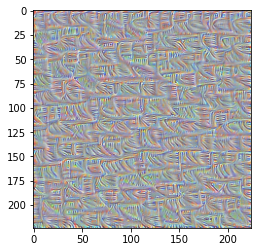

In [6]:
viz_vgg16 = visualize(model=model_vgg16, conv_layer=17, layer_filter=55)
viz_vgg16.execute(50, 0.8)

In [7]:
# visualize VGG19
model_vgg19

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Epoch: 0 loss: tensor(-2.6936, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 1 loss: tensor(-2.3911, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 2 loss: tensor(-2.2921, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 3 loss: tensor(-3.9534, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 4 loss: tensor(-6.6833, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 5 loss: tensor(-9.5961, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 6 loss: tensor(-13.2300, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 7 loss: tensor(-15.5581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 8 loss: tensor(-17.7437, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 9 loss: tensor(-20.9600, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 10 loss: tensor(-24.0998, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 11 loss: tensor(-26.0180, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 12 loss: tensor(-32.0396, dtype=torch.float64, grad_fn=<MeanB

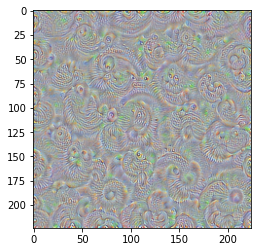

In [8]:
viz_vgg19 = visualize(model=model_vgg19, conv_layer=34, layer_filter=55)
viz_vgg19.execute(50, 0.8)

In [9]:
# visualize AlexNet
model_alexnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Epoch: 0 loss: tensor(-1.7774, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 1 loss: tensor(1.1476, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 2 loss: tensor(-2.3274, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 3 loss: tensor(-6.3941, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 4 loss: tensor(-9.0526, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 5 loss: tensor(-11.5621, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 6 loss: tensor(-14.1629, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 7 loss: tensor(-16.7233, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 8 loss: tensor(-18.3646, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 9 loss: tensor(-20.8123, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 10 loss: tensor(-22.6729, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 11 loss: tensor(-24.5681, dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch: 12 loss: tensor(-25.9433, dtype=torch.float64, grad_fn=<MeanB

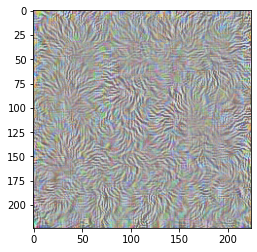

In [10]:
viz_alexnet = visualize(model=model_alexnet, conv_layer=10, layer_filter=1)
viz_alexnet.execute(50, 0.8)